In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi

In [2]:
# # Define the exact solution
# def exact_solution_u(x, t):
#     return (0.5*pi*torch.cos(x)+(x-pi*0.5))*torch.cos(t)

# def initial_condition_u(x):
#     return 0.5*pi*torch.cos(x) + (x - pi*0.5)

# def initial_condition_u_t(x):
#     return 0.0*pi*torch.cos(x) 



In [3]:
# Define the exact solution (cross-sectional rotation)
def exact_solution_u(x, t):
    return 0.5*pi*torch.sin(x)*torch.cos(t)

def initial_condition_u(x):
    return 0.5*pi*torch.sin(x)

def initial_condition_u_t(x):
    return 0.0*pi*torch.cos(x)

def acc_a(x, t):
    return -0.5*pi*torch.sin(x)*torch.cos(t)

In [4]:
# assigning number of points
initial_pts = 2000 
left_boundary_pts = 2000 
right_boundary_pts = 2000
residual_pts = 10000

In [5]:
# Additional data for acceleration

data_pts = 2000

x_1 = 0*torch.ones((data_pts)).reshape(-1,1)
x_2 = 0.25*pi*torch.ones((data_pts)).reshape(-1,1)
x_3 = 0.5*pi*torch.ones((data_pts)).reshape(-1,1)
x_4 = 0.75*pi*torch.ones((data_pts)).reshape(-1,1)
x_5 = pi*torch.ones((data_pts)).reshape(-1,1)

t_data_pts = torch.rand((data_pts, 1))

fir_loc = torch.cat([x_1, t_data_pts],1)
sec_loc = torch.cat([x_2, t_data_pts],1)
thr_loc = torch.cat([x_3, t_data_pts],1)
fou_loc = torch.cat([x_4, t_data_pts],1)
fif_loc = torch.cat([x_5, t_data_pts],1)

a1 = acc_a(fir_loc[:, 0], fir_loc[:, 1])
a2 = acc_a(sec_loc[:, 0], sec_loc[:, 1])
a3 = acc_a(thr_loc[:, 0], thr_loc[:, 1])
a4 = acc_a(fou_loc[:, 0], fou_loc[:, 1])
a5 = acc_a(fif_loc[:, 0], fif_loc[:, 1])

In [6]:
# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

x_init = pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init =  torch.cat([x_init, t_init],1)
u_init = initial_condition_u(init[:,0]).reshape(-1, 1)
# p_init = initial_condition_p(init[:,0]).reshape(-1, 1)
# w_init = torch.cat([u_init, p_init],1)

u_t_init = initial_condition_u_t(init[:,0]).reshape(-1, 1)
# p_t_init = initial_condition_p_t(init[:,0]).reshape(-1, 1)
# w_t_init = torch.cat([u_t_init, p_t_init],1)



xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = torch.rand((left_boundary_pts, 1)) # 
b_left = torch.cat([xb_left, tb_left ],1)
u_b_l = exact_solution_u(xb_left, tb_left)
# p_b_l = exact_solution_p(xb_left, tb_left)
# w_b_l = torch.cat([u_b_l, p_b_l],1)



xb_right = pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1)
u_b_r = exact_solution_u(xb_right, tb_right)
# p_b_r = exact_solution_p(xb_right, tb_right)
# w_b_r = torch.cat([u_b_r, p_b_r],1)

x_interior = pi*torch.rand((residual_pts, 1))
t_interior = torch.rand((residual_pts, 1))
interior = torch.cat([x_interior, t_interior],1)





training_set = DataLoader(torch.utils.data.TensorDataset(init, u_init, u_t_init, b_left,  b_right), batch_size=2000, shuffle=False)

In [7]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer 
        self.neurons = neurons
        # Number of hidden layers 
        self.n_hidden_layers = n_hidden_layers
        # Activation function 
        self.activation = nn.Tanh()
        
        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network 
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [8]:
# Model definition
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = 2, n_hidden_layers=4, neurons=20)


In [9]:
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)
#print(my_network(init))

In [10]:
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")

In [11]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()
    
    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])
        
        # Loop over batches
        for j, (initial, w_initial, w_initial_t, bd_left,  bd_right) in enumerate(training_set):
            
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                u_initial_pred_ = w_initial_pred_[:, 0].reshape(-1,1)
#                 p_initial_pred_ = w_initial_pred_[:,1].reshape(-1,1)
                
                
                # with derivative
                inpu = torch.ones(initial_pts, 1 )
                
                grad_u_ini = torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[0]
                
                u_initial_t = grad_u_ini[:, 1]
                
                
#                 grad_p_ini = torch.autograd.grad(p_initial_pred_, initial, grad_outputs=inpu, create_graph=True)[0]
                
#                 p_initial_t = grad_p_ini[:, 1]
                
                
                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                u_bd_left_pred_ = w_bd_left_pred_[:, 0].reshape(-1,1)
#                 p_bd_left_pred_ = w_bd_left_pred_[:,1].reshape(-1,1)
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                u_bd_right_pred_ = w_bd_right_pred_[:, 0].reshape(-1,1)
#                 p_bd_right_pred_ = w_bd_right_pred_[:,1].reshape(-1,1)
                
                # residual calculation
                fir_loc.requires_grad = True
                sec_loc.requires_grad = True
                thr_loc.requires_grad = True
                fou_loc.requires_grad = True
                fif_loc.requires_grad = True
              
                
                w_1 = model(fir_loc)
                w_2 = model(sec_loc)
                w_3 = model(thr_loc)
                w_4 = model(fou_loc)
                w_5 = model(fif_loc)
               
                
                # First Location
                
                u_hat1 = w_1[:, 0].reshape(-1,1)
                inputs = torch.ones(data_pts, 1 )
                grad_u_hat1 = torch.autograd.grad(u_hat1.reshape(-1,1),  fir_loc, grad_outputs=inputs, create_graph=True)[0]
                u_t1 = grad_u_hat1[:, 1].reshape(-1,1)
                grad_u_hat_tt1 = torch.autograd.grad(u_t1, fir_loc, grad_outputs=inputs, create_graph=True)[0]
                u_tt1 = grad_u_hat_tt1[:, 1].reshape(-1,1)
                
                u_x1 = grad_u_hat1[:, 0].reshape(-1,1)
                grad_u_hat_xx1 = torch.autograd.grad(u_x1, fir_loc, grad_outputs=inputs, create_graph=True)[0]
                u_xx1 = grad_u_hat_xx1[:, 0].reshape(-1,1)
                
                
                # Second Location
                u_hat2 = w_2[:, 0].reshape(-1,1)
                grad_u_hat2 = torch.autograd.grad(u_hat2.reshape(-1,1), sec_loc, grad_outputs=inputs, create_graph=True)[0]
                u_t2 = grad_u_hat2[:, 1].reshape(-1,1)
                grad_u_hat_tt2 = torch.autograd.grad(u_t2, sec_loc, grad_outputs=inputs, create_graph=True)[0]
                u_tt2 = grad_u_hat_tt2[:, 1].reshape(-1,1)
                u_x2 = grad_u_hat2[:, 0].reshape(-1,1)
                grad_u_hat_xx2 = torch.autograd.grad(u_x2, sec_loc, grad_outputs=inputs, create_graph=True)[0]
                u_xx2 = grad_u_hat_xx2[:, 0].reshape(-1,1)
                
                
                
                
                # Third Location
                
                u_hat3 = w_3[:, 0].reshape(-1,1)
                grad_u_hat3 = torch.autograd.grad(u_hat3.reshape(-1,1), thr_loc, grad_outputs=inputs, create_graph=True)[0]
                u_t3 = grad_u_hat3[:, 1].reshape(-1,1)
                grad_u_hat_tt3 = torch.autograd.grad(u_t3, thr_loc, grad_outputs=inputs, create_graph=True)[0]
                u_tt3 = grad_u_hat_tt3[:, 1].reshape(-1,1)
                
                u_x3 = grad_u_hat3[:, 0].reshape(-1,1)
                grad_u_hat_xx3 = torch.autograd.grad(u_x3, thr_loc, grad_outputs=inputs, create_graph=True)[0]
                u_xx3 = grad_u_hat_xx3[:, 0].reshape(-1,1)
                
                
                # Fourth Location
                
                u_hat4 = w_4[:, 0].reshape(-1,1)
                grad_u_hat4 = torch.autograd.grad(u_hat4.reshape(-1,1), fou_loc, grad_outputs=inputs, create_graph=True)[0]
                u_t4 = grad_u_hat4[:, 1].reshape(-1,1)
                grad_u_hat_tt4 = torch.autograd.grad(u_t4, fou_loc, grad_outputs=inputs, create_graph=True)[0]
                u_tt4 = grad_u_hat_tt4[:, 1].reshape(-1,1)
                
                u_x4 = grad_u_hat4[:, 0].reshape(-1,1)
                grad_u_hat_xx4 = torch.autograd.grad(u_x4, fou_loc, grad_outputs=inputs, create_graph=True)[0]
                u_xx4 = grad_u_hat_xx4[:, 0].reshape(-1,1)
                
                
                 
                # Fifth Location
                
                u_hat5 = w_5[:, 0].reshape(-1,1)
                grad_u_hat5 = torch.autograd.grad(u_hat5.reshape(-1,1), fif_loc, grad_outputs=inputs, create_graph=True)[0]
                u_t5 = grad_u_hat5[:, 1].reshape(-1,1)
                grad_u_hat_tt5 = torch.autograd.grad(u_t5, fif_loc, grad_outputs=inputs, create_graph=True)[0]
                u_tt5 = grad_u_hat_tt5[:, 1].reshape(-1,1)
                
                u_x5 = grad_u_hat5[:, 0].reshape(-1,1)
                grad_u_hat_xx5 = torch.autograd.grad(u_x5, fif_loc, grad_outputs=inputs, create_graph=True)[0]
                u_xx5 = grad_u_hat_xx5[:, 0].reshape(-1,1)
                
                

             
              
                data1 = torch.mean((u_tt1.reshape(-1, ) - a1.reshape(-1, ))**p)
                data2 = torch.mean((u_tt2.reshape(-1, ) - a2.reshape(-1, ))**p)
                data3 = torch.mean((u_tt3.reshape(-1, ) - a3.reshape(-1, ))**p)
                data4 = torch.mean((u_tt4.reshape(-1, ) - a4.reshape(-1, ))**p)
                data5 = torch.mean((u_tt5.reshape(-1, ) - a5.reshape(-1, ))**p)
                # Item 1. below
                
#                 # prediction for second output

                
                g1 = torch.cos(fir_loc[:, 1]).reshape(-1, ) - pi*0.5*torch.sin(fir_loc[:, 0])*torch.cos(fir_loc[:, 1]).reshape(-1, )
                g2 = torch.cos(sec_loc[:, 1]).reshape(-1, ) - pi*0.5*torch.sin(sec_loc[:, 0])*torch.cos(sec_loc[:, 1]).reshape(-1, )
                g3 = torch.cos(thr_loc[:, 1]).reshape(-1, ) - pi*0.5*torch.sin(thr_loc[:, 0])*torch.cos(thr_loc[:, 1]).reshape(-1, )
                g4 = torch.cos(fou_loc[:, 1]).reshape(-1, ) - pi*0.5*torch.sin(fou_loc[:, 0])*torch.cos(fou_loc[:, 1]).reshape(-1, )

                g5 = torch.cos(fif_loc[:, 1]).reshape(-1, ) - pi*0.5*torch.sin(fif_loc[:, 0])*torch.cos(fif_loc[:, 1]).reshape(-1, )
               
            #                 s1 = torch.mean((w_1[:, 1].reshape(-1, ) - u_tt1.reshape(-1, ))**p)
#                 s2 = torch.mean((w_2[:, 1].reshape(-1, ) - u_tt2.reshape(-1, ))**p)
#                 s3 = torch.mean((w_3[:, 1].reshape(-1, ) - u_tt3.reshape(-1, ))**p)
#                 s4 = torch.mean((w_4[:, 1].reshape(-1, ) -  u_tt4.reshape(-1, ))**p)
#                 s5 = torch.mean((w_5[:, 1].reshape(-1, ) -  u_tt5.reshape(-1, ))**p)
                
                o2_1st = torch.mean((w_1[:, 1].reshape(-1, ) - (g1.reshape(-1, ) - u_tt1.reshape(-1, ) + u_xx1.reshape(-1, ) ))**p)
                o2_2nd = torch.mean((w_2[:, 1].reshape(-1, ) - (g2.reshape(-1, ) - u_tt2.reshape(-1, ) + u_xx2.reshape(-1, ) ))**p)
                o2_3rd = torch.mean((w_3[:, 1].reshape(-1, ) - (g3.reshape(-1, ) - u_tt3.reshape(-1, ) + u_xx3.reshape(-1, ) ))**p)
                o2_4th = torch.mean((w_4[:, 1].reshape(-1, ) - (g4.reshape(-1, ) - u_tt4.reshape(-1, ) + u_xx4.reshape(-1, ) ))**p)
                o2_5th = torch.mean((w_5[:, 1].reshape(-1, ) - (g5.reshape(-1, ) - u_tt5.reshape(-1, ) + u_xx5.reshape(-1, ) ))**p)
#                 # prediction for third output
                
#                 t1 = torch.mean((w_1[:, 2].reshape(-1, ) - u_xx1.reshape(-1, ))**p)
#                 t2 = torch.mean((w_2[:, 2].reshape(-1, ) - u_xx2.reshape(-1, ))**p)
#                 t3 = torch.mean((w_3[:, 2].reshape(-1, ) - u_xx3.reshape(-1, ))**p)
#                 t4 = torch.mean((w_4[:, 2].reshape(-1, ) -  u_xx4.reshape(-1, ))**p)
#                 t5 = torch.mean((w_5[:, 2].reshape(-1, ) -  u_xx5.reshape(-1, ))**p)
                
               # loss = torch.mean((u_initial_t.reshape(-1, ) - w_initial_t.reshape(-1, ))**p)+torch.mean((u_initial_pred_.reshape(-1, ) - w_initial.reshape(-1, ))**p) + torch.mean((u_tt.reshape(-1, ) - acc_a(interior[:, 0], interior[:, 1]).reshape(-1, ) )**p)+torch.mean((u_bd_left_pred_.reshape(-1,) - u_b_l.reshape(-1,))**p) + torch.mean((u_bd_right_pred_.reshape(-1,) - u_b_r.reshape(-1,))**p)

                #loss = torch.mean((u_initial_t.reshape(-1, ) - w_initial_t[:, 0].reshape(-1, ))**p)
                
                loss1 = torch.mean((u_initial_t.reshape(-1, ) - w_initial_t.reshape(-1, ))**p)+torch.mean((u_initial_pred_.reshape(-1, ) - w_initial.reshape(-1, ))**p)+torch.mean((u_bd_left_pred_.reshape(-1,)- u_b_l.reshape(-1,))**p) + torch.mean((u_bd_right_pred_.reshape(-1,)- u_b_r.reshape(-1,))**p)
#                 loss2 = torch.mean((p_initial_pred_.reshape(-1, ) - w_initial[:,1].reshape(-1, ))**p)+ torch.mean((p_initial_t.reshape(-1, ) - w_initial_t[:,1].reshape(-1, ))**p) + 0.1*torch.mean((p_tt.reshape(-1, )  + u_x.reshape(-1, ) - p_xx.reshape(-1, ) - torch.cos(interior[:, 1]).reshape(-1, ) + pi*0.5*torch.sin(interior[:, 0])*torch.cos(interior[:, 1]).reshape(-1, ))**p)+torch.mean((p_bd_left_pred_.reshape(-1,)- p_b_l.reshape(-1,))**p) + torch.mean((p_bd_right_pred_.reshape(-1,)- p_b_r.reshape(-1,))**p)
#                 loss = loss1 + loss2
                #loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_t.reshape(-1, ) - u_xx.reshape(-1, ))))+torch.max(torch.abs((u_bd_left_pred_.reshape(-1,)))) + torch.max(torch.abs((u_bd_right_pred_.reshape(-1,))))
                #loss = loss1 + data1 + data2 + data3 + data4 + data5 + s1 + s2 + s3 +s4 +s5 + t1 + t2 + t3 + t4 + t5
                loss = loss1 + data1 + data2 + data3 + data4 + data5 +  o2_1st +  o2_2nd +  o2_3rd +  o2_4th +  o2_5th
                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss
            
            # Item 3. below
            optimizer.step(closure=closure)
            
        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [12]:
n_epochs = 15000
#history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )

In [13]:
# # # # saving and loading Model
FILE = "Displacement.pth"
#torch.save(my_network, FILE)

# # # # uncomment below when you need to test for different points
my_network = torch.load(FILE)
my_network.eval()

# # This model is saved with error 2.4866463616490364 %
# data is provided 10k points at 5 locations

NeuralNet(
  (activation): Tanh()
  (input_layer): Linear(in_features=2, out_features=20, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
  )
  (output_layer): Linear(in_features=20, out_features=2, bias=True)
)

In [15]:
x_test = torch.linspace(0, pi, 10000).reshape(-1,1)
t_test = torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test, t_test).reshape(-1,1)
# p_test = exact_solution_p(x_test, t_test).reshape(-1,1)
w_test_pred = my_network(test)
u_test_pred = w_test_pred[:, 0].reshape(-1,1)
# p_test_pred = w_test_pred[:,1].reshape(-1,1)

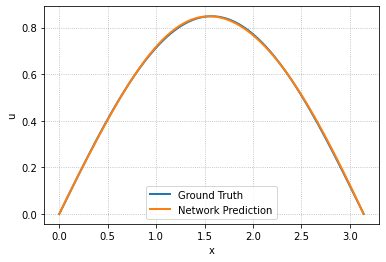

In [16]:
plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

In [17]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  0.0027391104595153593 %


In [18]:
def sec_out(x, t):
    return torch.cos(t) - 0.5*pi*torch.sin(x)*torch.cos(t)

s1 = sec_out(x_test, t_test).reshape(-1,1)
u_test_pred1 = w_test_pred[:, 1].reshape(-1,1)

In [19]:
# The quantity which we are sending from here to there:

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred1 - s1)**2)/torch.mean(s1**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

Relative Error Test:  9.193272888660431 %


In [ ]:
data = torch.cat((test, u_test_pred1 ),1)
print(data.shape)

np.savetxt('data_theta_x.csv' , [p for p in data.detach().numpy()],  delimiter=',' , fmt='%s')

In [ ]:
2+